In [1]:

# Import the required libraries.
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.regularizers import l2

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Specify the height and width of the images.
IMAGE_HEIGHT, IMAGE_WIDTH = 75, 75

SEQUENCE_LENGTH = 10
DATASET_DIR = "/content/drive/MyDrive/FYP/dataset"
CLASSES_LIST = ["After" , "Before"]

In [4]:
def load_images(class_name):
    images_list = []
    class_dir = os.path.join(DATASET_DIR, class_name)
    image_files = os.listdir(class_dir)
    image_files.sort()

    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_image = resized_image / 255.0
        images_list.append(normalized_image)

    return images_list

In [5]:
def create_dataset():
    features = []
    labels = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Loading data for class: {class_name}')
        images = load_images(class_name)

        for i in range(0, len(images) - SEQUENCE_LENGTH + 1, SEQUENCE_LENGTH):
            sequence = images[i:i+SEQUENCE_LENGTH]
            features.append(sequence)
            labels.append(class_index)
    np.save('features.npy', features)
    np.save('labels.npy' , labels)

    return np.array(features), np.array(labels)


In [6]:
features, labels = create_dataset()

Loading data for class: After
Loading data for class: Before


In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.05, shuffle=True, random_state=42)

In [8]:
# Reshape labels to match the model's output
labels_train = np.expand_dims(labels_train, axis=1)
labels_test = np.expand_dims(labels_test, axis=1)

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, TimeDistributed
from keras.applications import MobileNetV2  # Import MobileNetV2
from keras.optimizers import Adam
from keras.applications import InceptionV3
from keras.applications import ResNet50
from keras.applications import Xception
from keras.optimizers import SGD
from keras.layers import BatchNormalization


from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

def create_mobilenet_lstm_model(SEQUENCE_LENGTH):
    # Create a Sequential model
    model = Sequential()

    # Add MobileNetV2 model as the CNN base
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

    inception.trainable = False
    model.add(TimeDistributed(inception, input_shape=(SEQUENCE_LENGTH, 75, 75, 3)))
    #mobilenet.summary()

    #Flatten the output of ResNet
    model.add(TimeDistributed(Flatten()))

    # Add LSTM layers
    model.add(LSTM(64, return_sequences=True))
    #model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(BatchNormalization())

    # Add fully connected layers with dropout and L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.00001)))

    model.add(Dropout(0.7))  # Dropout layer to reduce overfitting
    model.add(Dense(1, activation='sigmoid'))

    #Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.1)  # Adjust the factor and patience as needed


    # Display the model summary
    model.summary()

    # Return the constructed CNN-LSTM model with ResNet50 as the CNN base
    return model, [early_stopping, reduce_lr]  # Use a list of callbacks


# Usage example:
SEQUENCE_LENGTH = 10  # Set your desired sequence length
model, early_stopping = create_mobilenet_lstm_model(SEQUENCE_LENGTH)

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 10, 1, 1, 2048)    21802784  
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 10, 2048)          0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 10, 64)            540928    
                                                                 
 batch_normalization_100 (B  (None, 10, 64)            256       
 atchNormalization)                                              
                                                                 
 dense_4 (Dense)             (None, 10, 64)            

In [25]:
from keras.callbacks import LearningRateScheduler
# Define a custom learning rate schedule function
def custom_learning_rate(epoch):
    # Define the initial learning rate
    initial_lr = 0.1

    # Set the learning rate to decrease by a factor of 0.1 every 10 epochs
    lr = initial_lr * (0.1 ** (epoch // 10))

    return lr
    # Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(custom_learning_rate)

In [26]:
# Compile the model
from keras.optimizers import RMSprop


#optimizer = Adam(learning_rate=0.0001)
optimizer = SGD(learning_rate=0.001, momentum=0.9)
#optimizer = RMSprop(learning_rate=0.1)

model.compile(loss='binary_crossentropy',  optimizer=optimizer, metrics=['accuracy'])

In [27]:
# Start training the model.
#history = model.fit(
    #x=features_train, y=labels_train, epochs=200, batch_size=128,
    #shuffle=True, validation_split=0.2, callbacks=[early_stopping,lr_scheduler])


# Start training the model.
history = model.fit(features_train,labels_train, epochs=200, batch_size=128,
    shuffle=True, callbacks=[early_stopping],validation_data=(features_test, labels_test))

Epoch 1/200
9/9 [==============================] - 34s 2s/step - loss: 0.9431 - accuracy: 0.5118 - val_loss: 0.6738 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 2s 270ms/step - loss: 0.8211 - accuracy: 0.5725 - val_loss: 0.6452 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 3/200
9/9 [==============================] - 2s 281ms/step - loss: 0.6982 - accuracy: 0.6398 - val_loss: 0.6178 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 4/200
9/9 [==============================] - 3s 296ms/step - loss: 0.6393 - accuracy: 0.6754 - val_loss: 0.5933 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 5/200
9/9 [==============================] - 2s 269ms/step - loss: 0.5874 - accuracy: 0.7085 - val_loss: 0.5710 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 6/200
9/9 [==============================] - 2s 266ms/step - loss: 0.5505 - accuracy: 0.7351 - val_loss: 0.5516 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 7/200
9/9 [==============================] - 2s 262ms/step - loss: 0.521

In [28]:
# Evaluate the trained model.
model_evaluation_history = model.evaluate(features_test, labels_test)

2/2 [==============================] - 4s 2s/step - loss: 0.1353 - accuracy: 0.9633


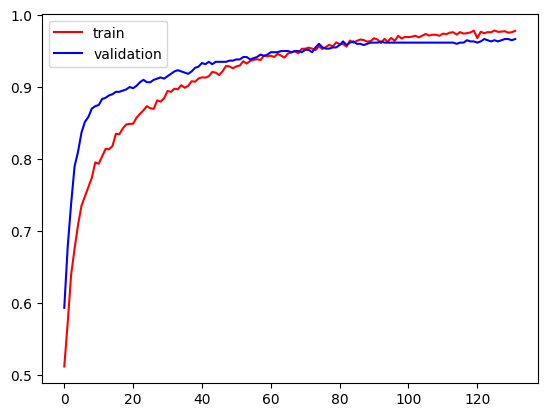

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

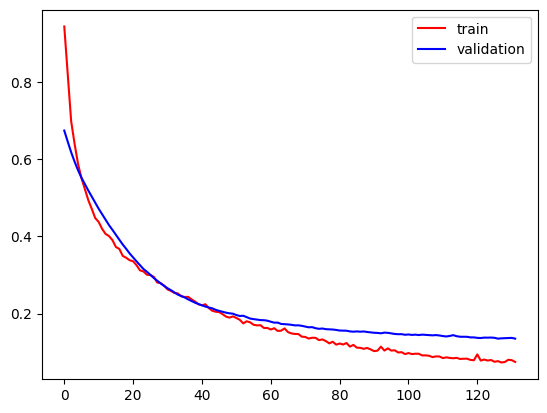

In [30]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()